#Projet 7 - Implémentez un modèle de scoring
##Partie 2: Tests et choix de l'algorithme
Dans cette partie, nous testons et comparons les différents algorithmes possibles pour ce projet.

J'importe les packages et les données.

In [5]:
import numpy as np
import pandas as pd
import gc
import time
import statistics
import collections
from sklearn import dummy
from sklearn import ensemble
from sklearn import metrics, model_selection
#from sklearn import utils
from sklearn.svm import LinearSVC
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
#from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics.cluster import adjusted_rand_score
#from imblearn.over_sampling import RandomOverSampler
#from imblearn.under_sampling import RandomUnderSampler
#from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
#import seaborn as sns
#import warnings
import time
#import math
#import joblib

from google.colab import files
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [6]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [7]:
fichiers = {'trainX': '126EsHRUCAZxvGI3cI-6hVVdMhzorLMyM',
            'testX': '1ub6d5sgJF-20lqWoXXlt4yjU-bCQs4Eq',
            'trainy': '1-FhtadsMTEZ_IA9G-aZEjGevdcU_TmCJ',
            'testy': '1-3ewg1u6YlrEagab9FFVqtlKrz2eD7af'}

In [8]:
for (i, (k, v)) in enumerate(fichiers.items()):
    downloaded = drive.CreateFile({'id':v})   # replace the id with id of file you want to access
    downloaded.GetContentFile(k + '.csv')        # replace the file name with your file

In [9]:
trainX = pd.read_csv('trainX.csv')
trainX = trainX.set_index(trainX.columns[0])
testX = pd.read_csv('testX.csv')
testX = testX.set_index(testX.columns[0])
trainy = pd.read_csv('trainy.csv')
trainy = trainy.set_index(trainy.columns[0])
testy = pd.read_csv('testy.csv')
testy = testy.set_index(testy.columns[0])

In [10]:
liste_features = [f for f in trainX.columns if f not in ['TARGET',
                                                        'SK_ID_CURR',
                                                        'SK_ID_BUREAU',
                                                        'SK_ID_PREV',
                                                        'index',
                                                        'REFUSED_APP_CREDIT_PERC_MAX',
                                                        'REFUSED_APP_CREDIT_PERC_MAX',
                                                        'PREV_APP_CREDIT_PERC_MAX',
                                                        'PREV_APP_CREDIT_PERC_MEAN',
                                                        'REFUSED_APP_CREDIT_PERC_MEAN',
                                                        'INSTAL_PAYMENT_PERC_MAX',
                                                        'INSTAL_PAYMENT_PERC_MEAN',
                                                        'INSTAL_PAYMENT_PERC_SUM'
                                                        ]]

# Création d'une référence.
J'utilise une classification "no skill" pour estimer, par comparaison, la qualité de mes modèles entraînés.

In [ ]:
# generate a no skill prediction (majority class)
#ns_probs = [1 for _ in range(len(testy))]
#ns_pred = [1 for _ in range(len(testy))]

# calculate scores
#ns_auc = roc_auc_score(testy, ns_probs)

In [ ]:
dummy_clf1 = dummy.DummyClassifier(strategy='most_frequent')
dummy_clf1.fit(trainX, trainy)

DummyClassifier(constant=None, random_state=None, strategy='most_frequent')

In [ ]:
d1_probs = dummy_clf1.predict_proba(testX)
d1_probs = d1_probs[:, 1]

J'estimerai la qualité du modèle en utilisant l'AUC score.
Dans le cas de notre classification "no skill", on obtient le score suivant

In [ ]:
roc_auc_score(testy, d1_probs)

0.5

J'affiche la ROC curve.

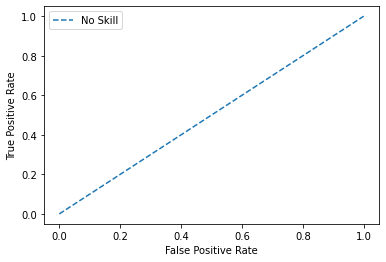

In [ ]:
d1_fpr, d1_tpr, _ = roc_curve(testy, d1_probs)
# plot the roc curve for the model
plt.plot(d1_fpr, d1_tpr, linestyle='--', label='No Skill')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

# Test des différents algorithmes de classification

Dans cette partie, j'essaie 5 algorithmes différents, de manière à choisir le plus adapté au travail que je dois faire par la suite.

Je vais faire pour chacun d'entre eux un essai d'optimisation des paramètres en validation croisée (et noter les meilleurs paramètres).
Je sélectionnerai le meilleur modèle sur la base de la qualité de la classification (score AUC), la stabilité du résultat entre les différents plis, et la vitesse de fit du modèle

In [11]:
folds = model_selection.KFold(n_splits=5, shuffle=True, random_state=166)

## Random Forest Classifier
Premier modèle testé: le Random Forest Classifier.  
J'utilise 2 paramètres: min_samples_split et max_depth. Je force un 3e: max_features.  
Si ce choix semble aléatoire, il ne l'est pas. Comme je l'ai fait pour les modèles suivants, j'ai déjà fait un certain nombre d'essais, et j'ai gardé des paramètres intéressants.

In [ ]:
# Fixer les valeurs des hyperparamètres à tester
param_grid = {'min_samples_split' : [5, 10, 15], 
              'max_features' : ['sqrt'], 
              'max_depth': [10, 15, 20]
              }

In [ ]:
# Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
score = 'roc_auc'

# Création du modèle: kernel ridge
rfc = model_selection.GridSearchCV(
    ensemble.RandomForestClassifier(class_weight = 'balanced'), # algo: regression ridge
    param_grid,     # hyperparamètres à tester
    cv=folds,           # nombre de folds de validation croisée
    scoring=score,  # score à optimiser
)

t0 = time.time()

# Optimiser ce classifieur sur le jeu d'entraînement
rfc.fit(np.nan_to_num(trainX), np.nan_to_num(trainy))

temps = time.time()-t0

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(rfc.best_params_)

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        rfc.cv_results_['mean_test_score'], # score moyen
        rfc.cv_results_['std_test_score'],  # écart-type du score
        rfc.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ) )

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 15}
Résultats de la validation croisée :
roc_auc = 0.747 (+/-0.004) for {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5}
roc_auc = 0.746 (+/-0.005) for {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 10}
roc_auc = 0.748 (+/-0.006) for {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 15}
roc_auc = 0.738 (+/-0.005) for {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 5}
roc_auc = 0.741 (+/-0.007) for {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 10}
roc_auc = 0.743 (+/-0.005) for {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 15}
roc_auc = 0.738 (+/-0.003) for {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 5}
roc_auc = 0.741 (+/-0.008) for {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 10}
roc_auc = 0.743 (+/-0.008) for {'max_depth': 20, 'max_feat

In [ ]:
print("Meilleur paramètre: min_samples_split = {}".format(rfc.best_params_['min_samples_split']))
print("Meilleur paramètre: max_features = {}".format(rfc.best_params_['max_features']))
print("Meilleur paramètre: max_depth = {}".format(rfc.best_params_['max_depth']))

Meilleur paramètre: min_samples_split = 15
Meilleur paramètre: max_features = sqrt
Meilleur paramètre: max_depth = 10


In [ ]:
j = np.where(
    (rfc.cv_results_['param_min_samples_split'] == rfc.best_params_['min_samples_split'])
    & (rfc.cv_results_['param_max_features'] == rfc.best_params_['max_features'])
    & (rfc.cv_results_['param_max_depth'] == rfc.best_params_['max_depth'])
    )
print('Score par pli (AC), meilleur paramètre:')
print("Score 1er pli:",np.around(rfc.cv_results_['split0_test_score'][j],3))
print("Score 2e pli:",np.around(rfc.cv_results_['split1_test_score'][j],3))
print("Score 3e pli:",np.around(rfc.cv_results_['split2_test_score'][j],3))
print("Score 4e pli:",np.around(rfc.cv_results_['split3_test_score'][j],3))
print("Score 5e pli:",np.around(rfc.cv_results_['split4_test_score'][j],3))

Moy = statistics.mean([
        rfc.cv_results_['split0_test_score'][j][0],
        rfc.cv_results_['split1_test_score'][j][0],
        rfc.cv_results_['split2_test_score'][j][0],
        rfc.cv_results_['split3_test_score'][j][0],
        rfc.cv_results_['split4_test_score'][j][0]])
print("Moyenne des scores par pli:", str(Moy))
Ec_type =  np.around(statistics.stdev([
            rfc.cv_results_['split0_test_score'][j][0],
            rfc.cv_results_['split1_test_score'][j][0],
            rfc.cv_results_['split2_test_score'][j][0],
            rfc.cv_results_['split3_test_score'][j][0],
            rfc.cv_results_['split4_test_score'][j][0]]),
                            3)

print("Ecart type des scores par pli:", str(Ec_type))

Score par pli (AC), meilleur paramètre:
Score 1er pli: [0.747]
Score 2e pli: [0.746]
Score 3e pli: [0.744]
Score 4e pli: [0.751]
Score 5e pli: [0.751]
Moyenne des scores par pli: 0.7478212666750024
Ecart type des scores par pli: 0.003


In [ ]:
print(temps)

6082.116996765137


## Gradient Boosting Classifier
2e modèle: Gradient Boosting Classifier.  
J'essaie 2 paramètres: learning_rate et max_depth.

In [ ]:
# Fixer les valeurs des hyperparamètres à tester
param_grid = {'learning_rate': [0.075, 0.1, 0.15],
            'max_depth':range(1,3)
             }

In [ ]:
# Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
score = 'roc_auc'

# Création du modèle: kernel ridge
gb = model_selection.GridSearchCV(
    GradientBoostingClassifier(), # algo: regression ridge
    param_grid,     # hyperparamètres à tester
    cv=folds,           # nombre de folds de validation croisée
    scoring=score,  # score à optimiser
)

t0 = time.time()

# Optimiser ce classifieur sur le jeu d'entraînement
gb.fit(np.nan_to_num(trainX), np.nan_to_num(trainy))

temps = time.time() - t0

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(gb.best_params_)

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        gb.cv_results_['mean_test_score'], # score moyen
        gb.cv_results_['std_test_score'],  # écart-type du score
        gb.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ) )

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 

In [ ]:
print("Meilleur paramètre: learning_rate = {}".format(gb.best_params_['learning_rate']))
print("Meilleur paramètre: max_depth = {}".format(gb.best_params_['max_depth']))

Meilleur paramètre: learning_rate = 0.15
Meilleur paramètre: max_depth = 2


In [ ]:
j = np.where(
    (gb.cv_results_['param_learning_rate'] == gb.best_params_['learning_rate'])
    & (gb.cv_results_['param_max_depth'] == gb.best_params_['max_depth'])
    )
print(j)
print('Score par pli (AC), meilleur paramètre:')
print("Score 1er pli:",np.around(gb.cv_results_['split0_test_score'][j],3))
print("Score 2e pli:",np.around(gb.cv_results_['split1_test_score'][j],3))
print("Score 3e pli:",np.around(gb.cv_results_['split2_test_score'][j],3))
print("Score 4e pli:",np.around(gb.cv_results_['split3_test_score'][j],3))
print("Score 5e pli:",np.around(gb.cv_results_['split4_test_score'][j],3))

Moy = np.around(statistics.mean([
        gb.cv_results_['split0_test_score'][j][0],
        gb.cv_results_['split1_test_score'][j][0],
        gb.cv_results_['split2_test_score'][j][0],
        gb.cv_results_['split3_test_score'][j][0],
        gb.cv_results_['split4_test_score'][j][0]]),
                      3)
print("Moyenne des scores par pli:", str(Moy))
Ec_type =  np.around(statistics.stdev([
            gb.cv_results_['split0_test_score'][j][0],
            gb.cv_results_['split1_test_score'][j][0],
            gb.cv_results_['split2_test_score'][j][0],
            gb.cv_results_['split3_test_score'][j][0],
            gb.cv_results_['split4_test_score'][j][0]]),
                            3)

print("Ecart type des scores par pli:", str(Ec_type))

(array([5]),)
Score par pli (AC), meilleur paramètre:
Score 1er pli: [0.766]
Score 2e pli: [0.766]
Score 3e pli: [0.763]
Score 4e pli: [0.77]
Score 5e pli: [0.768]
Moyenne des scores par pli: 0.767
Ecart type des scores par pli: 0.003


In [ ]:
print(temps)

22671.465352535248


## Logistic Regression
3e modèle: Logistic regression, avec 2 paramètres, max_iter et C.

In [ ]:
# Fixer les valeurs des hyperparamètres à tester
param_grid = {
            'max_iter': [2500],
            'C' : [0.0001, 0.001, 0.01, 0.1, 1]
             }

In [ ]:
# Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
score = 'roc_auc'

# Création du modèle: kernel ridge
lr = model_selection.GridSearchCV(
    LogisticRegression(class_weight = 'balanced'), # algo: regression ridge
    param_grid,     # hyperparamètres à tester
    cv=folds,           # nombre de folds de validation croisée
    scoring=score,  # score à optimiser
)

t0 = time.time()

# Optimiser ce classifieur sur le jeu d'entraînement
lr.fit(np.nan_to_num(trainX), np.nan_to_num(trainy))

temps = time.time() - t0

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(lr.best_params_)

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        lr.cv_results_['mean_test_score'], # score moyen
        lr.cv_results_['std_test_score'],  # écart-type du score
        lr.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ) )

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'C': 0.001, 'max_iter': 2500}
Résultats de la validation croisée :
roc_auc = 0.768 (+/-0.007) for {'C': 0.0001, 'max_iter': 2500}
roc_auc = 0.770 (+/-0.008) for {'C': 0.001, 'max_iter': 2500}
roc_auc = 0.769 (+/-0.008) for {'C': 0.01, 'max_iter': 2500}
roc_auc = 0.768 (+/-0.009) for {'C': 0.1, 'max_iter': 2500}
roc_auc = 0.768 (+/-0.009) for {'C': 1, 'max_iter': 2500}


In [ ]:
print("Meilleur paramètre: C = {}".format(lr.best_params_['C']))

Meilleur paramètre: C = 0.001


In [ ]:
j = np.where(
    (
      (lr.cv_results_['param_C'] == lr.best_params_['C'])
    ))
print(j)
print('Score par pli (AC), meilleur paramètre:')
print("Score 1er pli:",np.around(lr.cv_results_['split0_test_score'][j],3))
print("Score 2e pli:",np.around(lr.cv_results_['split1_test_score'][j],3))
print("Score 3e pli:",np.around(lr.cv_results_['split2_test_score'][j],3))
print("Score 4e pli:",np.around(lr.cv_results_['split3_test_score'][j],3))
print("Score 5e pli:",np.around(lr.cv_results_['split4_test_score'][j],3))

Moy = np.around(statistics.mean([
          lr.cv_results_['split0_test_score'][j][0],
          lr.cv_results_['split1_test_score'][j][0],
          lr.cv_results_['split2_test_score'][j][0],
          lr.cv_results_['split3_test_score'][j][0],
          lr.cv_results_['split4_test_score'][j][0]]),
                      3)
print("Moyenne des scores par pli:", str(Moy))
Ec_type = np.around(statistics.stdev([
                lr.cv_results_['split0_test_score'][j][0],
                lr.cv_results_['split1_test_score'][j][0],
                lr.cv_results_['split2_test_score'][j][0],
                lr.cv_results_['split3_test_score'][j][0],
                lr.cv_results_['split4_test_score'][j][0]]),
                                  3)

print("Ecart type des scores par pli:", str(Ec_type))

(array([1]),)
Score par pli (AC), meilleur paramètre:
Score 1er pli: [0.768]
Score 2e pli: [0.77]
Score 3e pli: [0.765]
Score 4e pli: [0.777]
Score 5e pli: [0.768]
Moyenne des scores par pli: 0.77
Ecart type des scores par pli: 0.005


In [ ]:
print(temps)

1656.5688273906708


## Light GBM
4e modèle: Light GBM. 3 paramètres à tester: n_estimators, learning_rate, num_leaves. J'utilise le boosting type dart.

In [ ]:
# Fixer les valeurs des hyperparamètres à tester
param_grid = {
            'boosting_type' : ['dart'],
            'n_estimators': [300, 400, 500],
            'learning_rate': [0.08, 0.1, 0.12],
            'num_leaves' : [16, 21, 26]
             }

In [ ]:
# Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
score = 'roc_auc'

# Création du modèle: kernel ridge
lgb = model_selection.GridSearchCV(
    LGBMClassifier(), # algo: regression ridge
    param_grid,     # hyperparamètres à tester
    cv=folds,           # nombre de folds de validation croisée
    scoring=score,  # score à optimiser
)

t0 = time.time()

# Optimiser ce classifieur sur le jeu d'entraînement
lgb.fit(trainX, trainy)

temps = time.time() - t0

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(lgb.best_params_)

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        lgb.cv_results_['mean_test_score'], # score moyen
        lgb.cv_results_['std_test_score'],  # écart-type du score
        lgb.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ) )

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'boosting_type': 'dart', 'learning_rate': 0.1, 'n_estimators': 500, 'num_leaves': 16}
Résultats de la validation croisée :
roc_auc = 0.775 (+/-0.004) for {'boosting_type': 'dart', 'learning_rate': 0.08, 'n_estimators': 300, 'num_leaves': 16}
roc_auc = 0.775 (+/-0.005) for {'boosting_type': 'dart', 'learning_rate': 0.08, 'n_estimators': 300, 'num_leaves': 21}
roc_auc = 0.776 (+/-0.004) for {'boosting_type': 'dart', 'learning_rate': 0.08, 'n_estimators': 300, 'num_leaves': 26}
roc_auc = 0.778 (+/-0.004) for {'boosting_type': 'dart', 'learning_rate': 0.08, 'n_estimators': 400, 'num_leaves': 16}
roc_auc = 0.779 (+/-0.006) for {'boosting_type': 'dart', 'learning_rate': 0.08, 'n_estimators': 400, 'num_leaves': 21}
roc_auc = 0.779 (+/-0.005) for {'boosting_type': 'dart', 'learning_rate': 0.08, 'n_estimators': 400, 'num_leaves': 26}
roc_auc = 0.780 (+/-0.005) for {'boosting_type': 'dart', 'learning_rate': 0.08, 'n_estimators': 500, 'num

In [ ]:
print("Meilleur paramètre: learning_rate = {}".format(lgb.best_params_['learning_rate']))
print("Meilleur paramètre: n_estimators = {}".format(lgb.best_params_['n_estimators']))
print("Meilleur paramètre: boosting_type = {}".format(lgb.best_params_['boosting_type']))
print("Meilleur paramètre: num_leaves = {}".format(lgb.best_params_['num_leaves']))

Meilleur paramètre: learning_rate = 0.1
Meilleur paramètre: n_estimators = 500
Meilleur paramètre: boosting_type = dart
Meilleur paramètre: num_leaves = 16


In [ ]:
j = np.where(
    (lgb.cv_results_['param_learning_rate'] == lgb.best_params_['learning_rate'])
    & (lgb.cv_results_['param_n_estimators'] == lgb.best_params_['n_estimators'])
    & (lgb.cv_results_['param_boosting_type'] == lgb.best_params_['boosting_type'])
    & (lgb.cv_results_['param_num_leaves'] == lgb.best_params_['num_leaves'])
    )
print(j)
print('Score par pli (AC), meilleur paramètre:')
print("Score 1er pli:",np.around(lgb.cv_results_['split0_test_score'][j],3))
print("Score 2e pli:",np.around(lgb.cv_results_['split1_test_score'][j],3))
print("Score 3e pli:",np.around(lgb.cv_results_['split2_test_score'][j],3))
print("Score 4e pli:",np.around(lgb.cv_results_['split3_test_score'][j],3))
print("Score 5e pli:",np.around(lgb.cv_results_['split4_test_score'][j],3))

Moy = np.around(statistics.mean([
    lgb.cv_results_['split0_test_score'][j][0],
     lgb.cv_results_['split1_test_score'][j][0],
     lgb.cv_results_['split2_test_score'][j][0],
     lgb.cv_results_['split3_test_score'][j][0],
     lgb.cv_results_['split4_test_score'][j][0]]),
                      3)
print("Moyenne des scores par pli:", str(Moy))

Ec_type = np.around(statistics.stdev([
    lgb.cv_results_['split0_test_score'][j][0],
     lgb.cv_results_['split1_test_score'][j][0],
     lgb.cv_results_['split2_test_score'][j][0],
     lgb.cv_results_['split3_test_score'][j][0],
     lgb.cv_results_['split4_test_score'][j][0]]),
                      3)
print("Ecart type des scores par pli:", str(Ec_type))

(array([15]),)
Score par pli (AC), meilleur paramètre:
Score 1er pli: [0.779]
Score 2e pli: [0.781]
Score 3e pli: [0.777]
Score 4e pli: [0.784]
Score 5e pli: [0.781]
Moyenne des scores par pli: 0.781
Ecart type des scores par pli: 0.003


In [ ]:
print(temps)

33725.65030837059


## MLP Classifier

In [ ]:
# Fixer les valeurs des hyperparamètres à tester
param_grid = {#'solver': ['lbfgs', 'sgd', 'adam'],
              'solver': ['adam'],
              'alpha': 10.0 ** -np.arange(2, 4), 
              'hidden_layer_sizes':np.arange(50, 91, 20)
             }

In [ ]:
# Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
score = 'roc_auc'

# Création du modèle: kernel ridge
mlp = model_selection.GridSearchCV(
    MLPClassifier(max_iter = 1000), # algo: regression ridge
    param_grid,     # hyperparamètres à tester
    cv=folds,           # nombre de folds de validation croisée
    scoring=score,  # score à optimiser
)

t0 = time.time()

# Optimiser ce classifieur sur le jeu d'entraînement
mlp.fit(np.nan_to_num(trainX), np.nan_to_num(trainy))

temps = time.time() - t0

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(mlp.best_params_)

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        mlp.cv_results_['mean_test_score'], # score moyen
        mlp.cv_results_['std_test_score'],  # écart-type du score
        mlp.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ) )

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d

In [ ]:
print("Meilleur paramètre: solver = {}".format(mlp.best_params_['solver']))
print("Meilleur paramètre: alpha = {}".format(mlp.best_params_['alpha']))
print("Meilleur paramètre: hidden_layer_sizes = {}".format(mlp.best_params_['hidden_layer_sizes']))

Meilleur paramètre: solver = adam
Meilleur paramètre: alpha = 0.01
Meilleur paramètre: hidden_layer_sizes = 50


In [ ]:
j = np.where(
    (mlp.cv_results_['param_solver'] == mlp.best_params_['solver'])
    & (mlp.cv_results_['param_alpha'] == mlp.best_params_['alpha'])
    & (mlp.cv_results_['param_hidden_layer_sizes'] == mlp.best_params_['hidden_layer_sizes'])
    )
print(j)
print('Score par pli (AC), meilleur paramètre:')
print("Score 1er pli:",np.around(mlp.cv_results_['split0_test_score'][j],3))
print("Score 2e pli:",np.around(mlp.cv_results_['split1_test_score'][j],3))
print("Score 3e pli:",np.around(mlp.cv_results_['split2_test_score'][j],3))
print("Score 4e pli:",np.around(mlp.cv_results_['split3_test_score'][j],3))
print("Score 5e pli:",np.around(mlp.cv_results_['split4_test_score'][j],3))

Moy = np.around(statistics.mean([
    mlp.cv_results_['split0_test_score'][j][0],
     mlp.cv_results_['split1_test_score'][j][0],
     mlp.cv_results_['split2_test_score'][j][0],
     mlp.cv_results_['split3_test_score'][j][0],
     mlp.cv_results_['split4_test_score'][j][0]]),
                      3)
print("Moyenne des scores par pli:", str(Moy))

Ec_type = np.around(statistics.stdev([
    mlp.cv_results_['split0_test_score'][j][0],
     mlp.cv_results_['split1_test_score'][j][0],
     mlp.cv_results_['split2_test_score'][j][0],
     mlp.cv_results_['split3_test_score'][j][0],
     mlp.cv_results_['split4_test_score'][j][0]]),
                      3)
print("Ecart type des scores par pli:", str(Ec_type))

(array([0]),)
Score par pli (AC), meilleur paramètre:
Score 1er pli: [0.66]
Score 2e pli: [0.659]
Score 3e pli: [0.665]
Score 4e pli: [0.651]
Score 5e pli: [0.658]
Moyenne des scores par pli: 0.658
Ecart type des scores par pli: 0.005


In [ ]:
print(temps)

23793.656547546387


# Amélioration du modèle choisi
Au vu des performances respectives des uns et des autres, je choisis le MLP classifier.
Je pars des dernières valeurs de paramètres sélectionnées, et j'affine la "grille" de sélection.

In [12]:
# Fixer les valeurs des hyperparamètres à tester
param_grid = {
            'boosting_type' : ['dart'],
            'n_estimators': [500, 550, 600],
            'learning_rate': [0.08, 0.09, 0.1],
            'num_leaves' : [14, 16, 18]
             }

In [ ]:
# Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
score = 'roc_auc'

# Création du modèle: kernel ridge
lgb = model_selection.GridSearchCV(
    LGBMClassifier(), # algo: regression ridge
    param_grid,     # hyperparamètres à tester
    cv=folds,           # nombre de folds de validation croisée
    scoring=score,  # score à optimiser
)

t0 = time.time()

# Optimiser ce classifieur sur le jeu d'entraînement
lgb.fit(trainX, trainy)

temps = time.time() - t0

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(lgb.best_params_)

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        lgb.cv_results_['mean_test_score'], # score moyen
        lgb.cv_results_['std_test_score'],  # écart-type du score
        lgb.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ) )

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'boosting_type': 'dart', 'learning_rate': 0.09, 'n_estimators': 550, 'num_leaves': 16}
Résultats de la validation croisée :
roc_auc = 0.780 (+/-0.006) for {'boosting_type': 'dart', 'learning_rate': 0.08, 'n_estimators': 500, 'num_leaves': 14}
roc_auc = 0.780 (+/-0.005) for {'boosting_type': 'dart', 'learning_rate': 0.08, 'n_estimators': 500, 'num_leaves': 16}
roc_auc = 0.780 (+/-0.006) for {'boosting_type': 'dart', 'learning_rate': 0.08, 'n_estimators': 500, 'num_leaves': 18}
roc_auc = 0.780 (+/-0.006) for {'boosting_type': 'dart', 'learning_rate': 0.08, 'n_estimators': 550, 'num_leaves': 14}
roc_auc = 0.781 (+/-0.005) for {'boosting_type': 'dart', 'learning_rate': 0.08, 'n_estimators': 550, 'num_leaves': 16}
roc_auc = 0.781 (+/-0.006) for {'boosting_type': 'dart', 'learning_rate': 0.08, 'n_estimators': 550, 'num_leaves': 18}
roc_auc = 0.780 (+/-0.006) for {'boosting_type': 'dart', 'learning_rate': 0.08, 'n_estimators': 600, 'nu

In [ ]:
print("Meilleur paramètre: learning_rate = {}".format(lgb.best_params_['learning_rate']))
print("Meilleur paramètre: n_estimators = {}".format(lgb.best_params_['n_estimators']))
print("Meilleur paramètre: boosting_type = {}".format(lgb.best_params_['boosting_type']))
print("Meilleur paramètre: num_leaves = {}".format(lgb.best_params_['num_leaves']))

Meilleur paramètre: learning_rate = 0.09
Meilleur paramètre: n_estimators = 550
Meilleur paramètre: boosting_type = dart
Meilleur paramètre: num_leaves = 16


In [ ]:
j = np.where(
    (lgb.cv_results_['param_learning_rate'] == lgb.best_params_['learning_rate'])
    & (lgb.cv_results_['param_n_estimators'] == lgb.best_params_['n_estimators'])
    & (lgb.cv_results_['param_boosting_type'] == lgb.best_params_['boosting_type'])
    & (lgb.cv_results_['param_num_leaves'] == lgb.best_params_['num_leaves'])
    )
print(j)
print('Score par pli (AC), meilleur paramètre:')
print("Score 1er pli:",np.around(lgb.cv_results_['split0_test_score'][j],3))
print("Score 2e pli:",np.around(lgb.cv_results_['split1_test_score'][j],3))
print("Score 3e pli:",np.around(lgb.cv_results_['split2_test_score'][j],3))
print("Score 4e pli:",np.around(lgb.cv_results_['split3_test_score'][j],3))
print("Score 5e pli:",np.around(lgb.cv_results_['split4_test_score'][j],3))

Moy = np.around(statistics.mean([
    lgb.cv_results_['split0_test_score'][j][0],
     lgb.cv_results_['split1_test_score'][j][0],
     lgb.cv_results_['split2_test_score'][j][0],
     lgb.cv_results_['split3_test_score'][j][0],
     lgb.cv_results_['split4_test_score'][j][0]]),
                      3)
print("Moyenne des scores par pli:", str(Moy))

Ec_type = np.around(statistics.stdev([
    lgb.cv_results_['split0_test_score'][j][0],
     lgb.cv_results_['split1_test_score'][j][0],
     lgb.cv_results_['split2_test_score'][j][0],
     lgb.cv_results_['split3_test_score'][j][0],
     lgb.cv_results_['split4_test_score'][j][0]]),
                      3)
print("Ecart type des scores par pli:", str(Ec_type))

(array([13]),)
Score par pli (AC), meilleur paramètre:
Score 1er pli: [0.78]
Score 2e pli: [0.781]
Score 3e pli: [0.777]
Score 4e pli: [0.786]
Score 5e pli: [0.781]
Moyenne des scores par pli: 0.781
Ecart type des scores par pli: 0.003
